In [6]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
import pickle

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [2]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = 'home/calpeyser/sketch/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  #display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

cat_model_dir = "/home/calpeyser/checkpoints/cat/"
dog_model_dir = "/home/calpeyser/checkpoints/dog/"
cat_data_dir = "/home/calpeyser/sketch/data/cat/"
dog_data_dir = "/home/calpeyser/sketch/data/dog/"
flam_model_dir = "/home/calpeyser/sketch/models/flamingo/lstm_uncond"
flam_data_dir = "/home/calpeyser/sketch/data/flamingo/"


INFO:tensorflow:TensorFlow Version: 1.2.1


In [3]:

[cat_train_set, cat_valid_set, cat_test_set, cat_hps_model, cat_eval_hps_model, cat_sample_hps_model] = load_env(cat_data_dir, cat_model_dir)
cat_eval_model = Model(cat_eval_hps_model, reuse=False)
cat_sample_model = Model(cat_sample_hps_model, reuse=True)
[dog_train_set, dog_valid_set, dog_test_set, dog_hps_model, dog_eval_hps_model, dog_sample_hps_model] = load_env(dog_data_dir, dog_model_dir)
dog_eval_model = Model(dog_eval_hps_model, reuse=True)
dog_sample_model = Model(dog_sample_hps_model, reuse=True)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Loaded 70000/2500/2500 from extended_flamingo.npz
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 51
INFO:tensorflow:model_params.max_seq_len 91.
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
INFO:tensorflow:normalizing_scale_factor 44.1712.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [4]:
def encode(eval_model, input_strokes, max_len=129):
  strokes = to_big_strokes(input_strokes, max_len=max_len).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  #draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]
def decode(eval_model, sample_model, z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  return strokes

In [ ]:
load_checkpoint(sess, cat_model_dir)
cat = cat_test_set.random_sample()
print(cat.shape)
encoding = encode(cat_eval_model, cat)
decoding = decode(cat_eval_model, cat_sample_model, encoding)

draw_strokes(cat)
print(encoding)
draw_strokes(decoding)
 

In [5]:
# Generate dataset
for i in range(1000):
    draw_strokes(cat_train_set.strokes[i], svg_filename="/home/calpeyser/sketch/sketches/cat/" + str(i) + ".svg")
    if (i % 100 == 0):
        print(i)

0
100
200
300
400
500
600
700
800
900


In [26]:
# Obtain traning data from manually labeled dataset
labels = [(264,432),
(278,441),
(528,196),
(517,311),
(525,281),
(642,441),
(651,345),
(531,383),
(533,381),
(618,432),
(814,511),
(839,378),
(565,443),
(553,505),
(706,641),
(913,0),
(137,1),
(251,2),
(711,8),
(243,230),
(451,220),
(832,632),
(984,307),
(944,352),
(593,307),
(21,389)]

"""
category_labels = {
    "cat": {
        "no_features": [3,4,17,23,65,66,106,152,205,236,239,240,304,322,325,344,369,381,382,394],
        "features": [2,7,8,9,10,15,16,19,20,26,28,30,35,46,188,204,208,228,434,657],
        "body": [12,21,177,112,332,659,714,697,0,1,129,696,552,659,692,781,787,833,866,944],
    },
    "dog": {
        "no_features": [49,64,205,221,222,248,282,283,378,425,441,443,459,500,613,607,619,713,747,791],
        "features": [3,26,41,73,92,167,177,196,311,329,383,398,587,639,689,743,787,792,829,877],
        "body": [0,1,2,8,9,11,337,343,352,364,367,388,446,467,479,492,494,504,518,552],
    }
}
"""
category_labels = {
    "cat": {
        "whiskers": [16,25,34,51,53,80,82,130,156,192,291,292,305,327,333,375,417,422,440,478,489,577,594,654,704,898,940,957],
        "no_whiskers": [3,4,17,19,23,29,33,65,66,90,106,114,152,186,218,228,253,278,279,283,284,288,290,295,296,335,338,334,360,369],
    },
    "dog": {
        "body": [0,1,2,8,9,11,337,343,352,364,367,388,446,467,479,492,494,504,518,552],
        "face": [49,64,205,221,222,248,282,283,378,425,3,26,41,73,92,167,177,196,311],
    }
}

# load cat model, map sketches onto embeddings
load_checkpoint(sess, cat_model_dir)
labels = [(encode(cat_eval_model, cat_train_set.strokes[label[0]]), label[1]) for label in labels]

category_labels["cat"]["whiskers"] = [encode(cat_eval_model, cat_train_set.strokes[i]) for i in category_labels["cat"]["whiskers"]]
category_labels["cat"]["no_whiskers"] = [encode(cat_eval_model, cat_train_set.strokes[i]) for i in category_labels["cat"]["no_whiskers"]]


# load dog model, map sketches onto embeddings
load_checkpoint(sess, dog_model_dir)
labels = [(label[0], encode(dog_eval_model, dog_train_set.strokes[label[1]], max_len=133)) for label in labels]

category_labels["dog"]["face"] = [encode(dog_eval_model, dog_train_set.strokes[i], max_len=133) for i in category_labels["dog"]["face"]]
category_labels["dog"]["body"] = [encode(dog_eval_model, dog_train_set.strokes[i], max_len=133) for i in category_labels["dog"]["body"]]


INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-44500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-44500
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-39500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-39500


In [6]:
# Sanity check labels
cats = []
dogs = []

# Decode cats
load_checkpoint(sess, cat_model_dir)
for cat in category_labels["cat"]["no_features"]:
    decoding = decode(cat_eval_model, cat_sample_model, cat)
    cats.append(decoding)
    
# Decode dogs
load_checkpoint(sess, dog_model_dir)
for dog in category_labels["dog"]["no_features"]:
    decoding = decode(dog_eval_model, dog_sample_model, dog)
    dogs.append(decoding)
    
for cat, dog in zip(cats, dogs):
    draw_strokes(cat)
    draw_strokes(dog)
    print("---------")


INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-44500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-44500


KeyboardInterrupt: 

In [28]:
# Train a linear model on the sketch labels
STARTER_LEARNING_RATE = 0.04
EXAMPLE_COUNT = 20000

linear_graph = tf.Graph()
with linear_graph.as_default():
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(STARTER_LEARNING_RATE, global_step, 10000, 0.96, staircase=True)


    # TF graph input
    X = tf.placeholder("float64")
    Y = tf.placeholder("float64")

    # TF weights
    # Matrix version
    #W = tf.Variable(np.random.rand(128, 128), name = "linear_model_weight")
    W = tf.Variable(np.random.rand(128), name = "linear_model_weight")
    b = tf.Variable(np.random.rand(128), name = "linear_model_bias")

    # Matrix version
    #prediction = tf.squeeze(tf.add(tf.matmul(tf.expand_dims(X, 0), W), b))
    prediction = tf.add(tf.multiply(X, W), b)
    #prediction = tf.multiply(X, W)
    
    #cost = tf.reduce_sum(tf.pow(prediction - Y, 2)/(2*len(labels)))
    cost = tf.losses.mean_squared_error(Y, prediction)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost, global_step=global_step)

    init = tf.variables_initializer([W, b, global_step])

linear_model_sess = tf.Session(graph=linear_graph)
linear_model_sess.run(init)
costs = []
for example_num in range(EXAMPLE_COUNT):
    idx = random.randint(0,1)
    cat_category = ["whiskers", "no_whiskers"][idx] # choose a random category
    dog_category = ["body", "face"][idx]
    # Choose a cat and dog in the given category at random
    cat = category_labels["cat"][cat_category][random.randint(0, len(category_labels["cat"][cat_category]) - 1)]
    dog = category_labels["dog"][dog_category][random.randint(0, len(category_labels["dog"][dog_category]) - 1)]
    
    _, cost_ = linear_model_sess.run([optimizer, cost], feed_dict={X: dog, Y: cat})
    costs.append(cost_)
    
    if (example_num % 1000) == 0:
        cost_computed = sum(costs)/len(costs)
        costs = []
        print("Example: %s, Cost: %s " % (example_num, cost_computed))

#W_computed = linear_model_sess.run(W, feed_dict = {X: x, Y: y})
#b_computed = linear_model_sess.run(b, feed_dict = {X: x, Y: y})
#print("Results: W=%s, b=%s " % (W_computed, b_computed))



Example: 0, Cost: 1.6359671354293823 
Example: 1000, Cost: 1.3007461177110673 
Example: 2000, Cost: 1.0275475090742112 
Example: 3000, Cost: 0.9483895733356476 
Example: 4000, Cost: 0.9245936219096184 
Example: 5000, Cost: 0.9168926807045936 
Example: 6000, Cost: 0.913632543683052 
Example: 7000, Cost: 0.9129218252301217 
Example: 8000, Cost: 0.9170246350765229 
Example: 9000, Cost: 0.9061343241333961 
Example: 10000, Cost: 0.9098874117136002 
Example: 11000, Cost: 0.9093554470539092 
Example: 12000, Cost: 0.9073781830668449 
Example: 13000, Cost: 0.9147624940276146 
Example: 14000, Cost: 0.9151394242048263 
Example: 15000, Cost: 0.9105708746910095 
Example: 16000, Cost: 0.9134480924010276 
Example: 17000, Cost: 0.9155975900888443 
Example: 18000, Cost: 0.9246858736872673 
Example: 19000, Cost: 0.9207450420260429 


In [ ]:
print(labels[1][1].shape)

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-39500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-39500


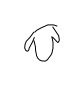

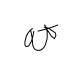

[-0.17004287  1.0632007  -0.42562956 -2.5077884  -0.4543007   1.2592939  -1.5345033  -0.8763803   0.66772604  0.17925927  0.24241959 -0.41415718  1.960595    1.2979765  -0.0912848   0.7070796
 -1.2698083  -0.34069228  1.7906183   1.4190719   0.05958739 -0.84739786 -1.2770425   0.5228816  -0.03796715  1.767975   -0.8996261  -0.55249935 -1.1121467  -1.6100472  -0.36529216 -1.4851567
 -0.14670372  0.5905113   1.5448061  -0.863067    1.748891   -0.66753453  0.9446664  -0.6081131   0.4662076  -0.99289745 -0.01435357  1.2988509  -0.5713644  -1.1524765   0.02176306  0.63930553
  0.6157552  -1.1120036   0.13858253 -0.6919478  -0.5820037   0.00355811  1.3730636  -0.74187934  0.32739264 -1.8729683  -0.5684488   1.6518788   0.8916714  -0.8057381  -0.5354064  -0.39192018
 -0.5615386  -0.67149585 -0.30619866 -1.1707875  -1.1330644   0.7504291  -1.2979755   0.02891912  0.0990271  -0.16878918  0.4465235   1.4107416  -1.0400707   1.7997153   0.21565403  0.55318826
 -0.5548497  -0.8726244   0.28933597 

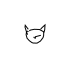

In [36]:
# Lets do some predictions
load_checkpoint(sess, dog_model_dir)
dog = dog_train_set.strokes[205]
draw_strokes(dog)
encoding = encode(dog_eval_model, dog, max_len=133)
draw_strokes(decode(dog_eval_model, dog_sample_model, encoding))
print(encoding)
predicted_encoding = linear_model_sess.run(prediction, feed_dict = {X: encoding})
load_checkpoint(sess, cat_model_dir)
decoding = decode(cat_eval_model, cat_sample_model, predicted_encoding)
draw_strokes(decoding)
